<a href="https://www.kaggle.com/code/roarhun/pneumonia-classification?scriptVersionId=239908696" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

**Pneumonia **

Pneumonia is an infection that inflames the air sacs in one or both lungs, causing them to fill with fluid or pus, which can lead to coughing, fever, and breathing difficulties

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1947_bacteria_4876.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1946_bacteria_4875.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1952_bacteria_4883.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1954_bacteria_4886.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1951_bacteria_4882.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1946_bacteria_4874.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1949_bacteria_4880.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/per

# Install necessary libraries

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
import os
import numpy as np

2025-05-15 14:47:42.475356: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747320462.739623      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747320462.818532      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# Read Data & Augmentation

In [4]:
# Data augmentation สำหรับ train set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    zoom_range=0.3,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    brightness_range=[0.8,1.2],
    horizontal_flip=True,
    fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)
# โหลดภาพ
train_generator = train_datagen.flow_from_directory(
    '../input/chest-xray-pneumonia/chest_xray/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary')

val_generator = val_datagen.flow_from_directory(
    '../input/chest-xray-pneumonia/chest_xray/val',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary')

test_generator = val_datagen.flow_from_directory(
    '../input/chest-xray-pneumonia/chest_xray/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False)  


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


# Visualization

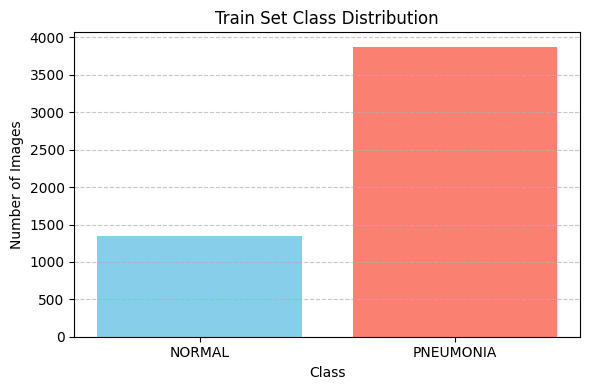

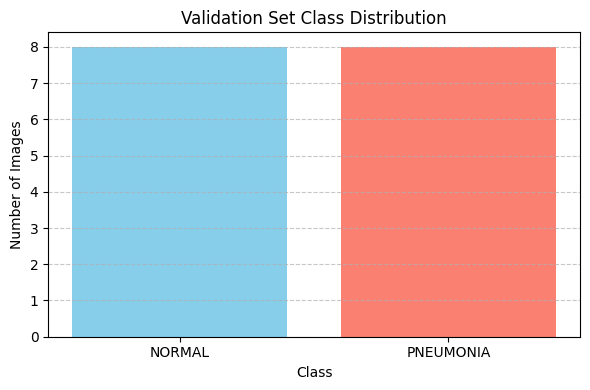

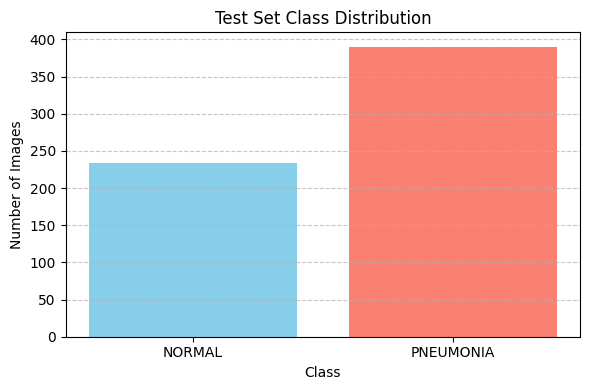

In [5]:
import matplotlib.pyplot as plt
import numpy as np

def plot_class_distribution(generator, title):
    class_indices = generator.class_indices  # เช่น {'NORMAL': 0, 'PNEUMONIA': 1}
    labels = list(class_indices.keys())
    class_counts = np.bincount(generator.classes)

    plt.figure(figsize=(6, 4))
    plt.bar(labels, class_counts, color=['skyblue', 'salmon'])
    plt.title(title)
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# แสดงกราฟสำหรับแต่ละชุดข้อมูล
plot_class_distribution(train_generator, 'Train Set Class Distribution')
plot_class_distribution(val_generator, 'Validation Set Class Distribution')
plot_class_distribution(test_generator, 'Test Set Class Distribution')


In [6]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-05-15 14:48:02.879833: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Complie

In [7]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])
# model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
# model.summary()

Train

In [8]:
history = model.fit(train_generator,
                    epochs=40,
                    validation_data=val_generator)

Epoch 1/40


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


163/163 ━━━━━━━━━━━━━━━━━━━━ 409s 2s/step - accuracy: 0.7614 - loss: 0.4999 - val_accuracy: 0.6250 - val_loss: 0.9759
Epoch 2/40
163/163 ━━━━━━━━━━━━━━━━━━━━ 436s 2s/step - accuracy: 0.8277 - loss: 0.3737 - val_accuracy: 0.5625 - val_loss: 0.8790
Epoch 3/40
163/163 ━━━━━━━━━━━━━━━━━━━━ 395s 2s/step - accuracy: 0.8564 - loss: 0.3110 - val_accuracy: 0.5625 - val_loss: 0.6647
Epoch 4/40
163/163 ━━━━━━━━━━━━━━━━━━━━ 395s 2s/step - accuracy: 0.8704 - loss: 0.2988 - val_accuracy: 0.6250 - val_loss: 0.7869
Epoch 5/40
163/163 ━━━━━━━━━━━━━━━━━━━━ 438s 2s/step - accuracy: 0.8660 - loss: 0.2927 - val_accuracy: 0.5625 - val_loss: 0.7718
Epoch 6/40
163/163 ━━━━━━━━━━━━━━━━━━━━ 444s 2s/step - accuracy: 0.8872 - loss: 0.2642 - val_accuracy: 0.5625 - val_loss: 0.6013
Epoch 7/40
163/163 ━━━━━━━━━━━━━━━━━━━━ 440s 2s/step - accuracy: 0.8978 - loss: 0.2434 - val_accuracy: 0.5625 - val_loss: 0.7399
Epoch 8/40
163/163 ━━━━━━━━━━━━━━━━━━━━ 441s 2s/step - accuracy: 0.8953 - loss: 0.2363 - val_accuracy: 0.687

In [9]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 782ms/step


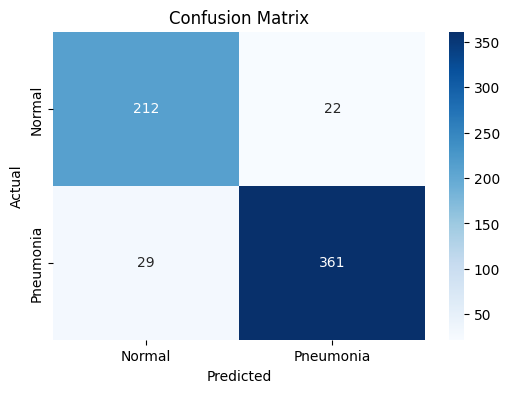

              precision    recall  f1-score   support

      Normal       0.88      0.91      0.89       234
   Pneumonia       0.94      0.93      0.93       390

    accuracy                           0.92       624
   macro avg       0.91      0.92      0.91       624
weighted avg       0.92      0.92      0.92       624



In [10]:
import seaborn as sns
y_pred_prob = model.predict(test_generator)
y_pred = (y_pred_prob > 0.5).astype(int).reshape(-1)
y_true = test_generator.classes

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print(classification_report(y_true, y_pred, target_names=['Normal', 'Pneumonia']))
